# 目标：学习使用"sklearn",机器学习lib
1.交叉验证确保模型不会过拟合
2.使用参数调整和网格搜索寻找最优分类算法
3.XGBoost是一个新的流行算法包，！！！我的电脑暂时装不上去
code from "Scikit-Learn ML from Start to Finish"
https://www.kaggle.com/jeffd23/titanic/scikit-learn-ml-from-start-to-finish

## 学习步骤：
1.导入数据importing
2.可视化数据visualize
3.清洗转换数据clean&transform
4.数据标签数值化encode
5.拆分训练集和测试集split
6.算法调整
7.交叉验证KFold
8.提交kaggle

In [17]:
#导入数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data_train=pd.read_csv(r"train.csv")
data_test=pd.read_csv(r"train.csv")

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
750,751,1,2,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S
731,732,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,2699,18.7875,NaN,C


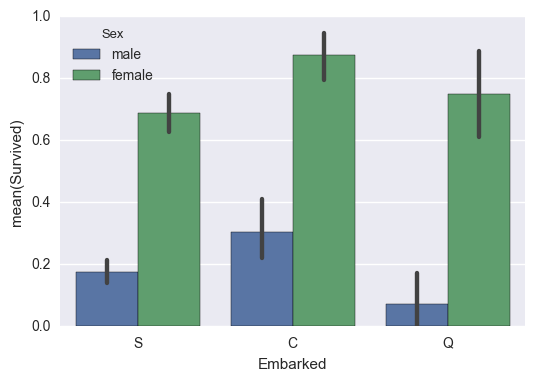

In [18]:
#数据可视化
sns.barplot(x="Embarked",y="Survived",hue="Sex",data=data_train)

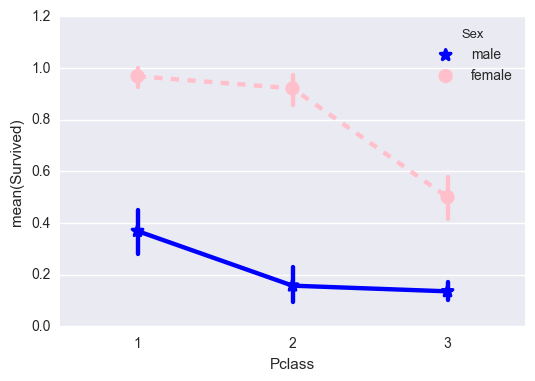

In [19]:
sns.pointplot(x="Pclass",y="Survived",hue="Sex",data=data_train,palette={"male":"blue","female":"pink"},markers=["*","o"],linestyles=["-","--"])

In [20]:
#特征转换
def simplify_ages(df):
    df.Age=df.Age.fillna(-0.5)
    bins=(-1,0,5,12,18,25,35,60,120)
    group_names=["unkonw","Baby","child",
                 "teenger","student","young adult","adult","senior"]
    categories=pd.cut(df.Age,bins,labels=group_names)
    df.Age=categories
    return df

def simplify_cabins(df):
    df.Cabin=df.Cabin.fillna("N")
    df.Cabin=df.Cabin.apply(lambda x:x[0])
    return df 

def simplify_fares(df):
    df.Fare=df.Fare.fillna(-0.5)
    bins=(-1,0,8,15,31,1000)
    group_names=["unknow","1_quartile","2_quartile","3_quartile","4_quartile"]
    categories=pd.cut(df.Fare,bins,labels=group_names)
    df.Fare=categories
    return df

def format_name(df):
    df["Lname"]=df.Name.apply(lambda x:x.split(" ")[0])
    df["NamePrefix"]=df.Name.apply(lambda x:x.split(" ")[1])
    return df

def drop_features(df):
    return df.drop(["Ticket","Name","Embarked"],axis=1)

def tranform_features(df):
    df=simplify_ages(df)
    df=simplify_cabins(df)
    df=simplify_fares(df)
    df=format_name(df)
    df=drop_features(df)
    return df

data_train=tranform_features(data_train)
data_test=tranform_features(data_test)
data_train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,young adult,0,0,1_quartile,N,"Heikkinen,",Miss.


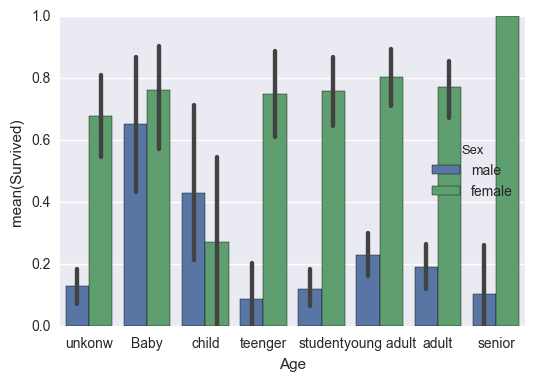

In [21]:
sns.barplot(x="Age",y="Survived",hue="Sex",data=data_train)

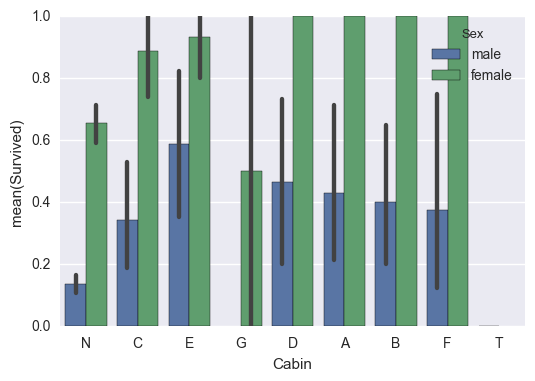

In [22]:
sns.barplot(x="Cabin",y="Survived",hue="Sex",data=data_train)

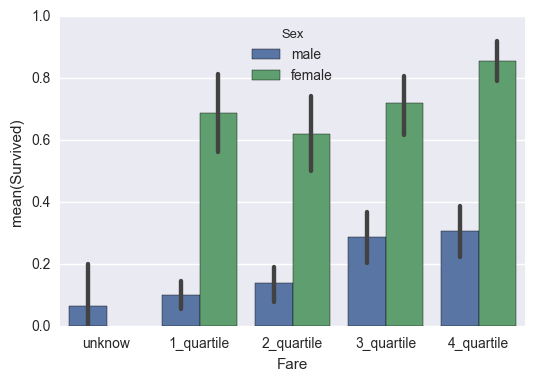

In [23]:
sns.barplot(x="Fare",y="Survived",hue="Sex",data=data_train)

In [24]:
#标签数值化
#normalize labels "method in the labelencoder"
#result a table of numbers
from sklearn import preprocessing
def encode_features(df_train,df_test):
    features=["Fare","Cabin","Age","Sex","Lname","NamePrefix"]
    df_combined=pd.concat([df_train[features],df_test[features]])
    
    for feature in features:
        le=preprocessing.LabelEncoder()
        le=le.fit(df_combined[feature])
        df_train[feature]=le.transform(df_train[feature])
        df_test[feature]=le.transform(df_test[feature])
    return df_train,df_test


In [25]:
data_train,data_test=encode_features(data_train,data_test)
data_train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,73,17
1,2,1,1,0,1,1,0,3,2,136,18
2,3,1,3,0,7,0,0,0,7,251,14


In [28]:
#分割数据splitting 
#80%训练集分割
from sklearn.model_selection import train_test_split
x_all=data_train.drop(["Survived","PassengerId"],axis=1)
y_all=data_train["Survived"]

num_test=0.2
x_train,x_test,y_train,y_test=train_test_split(x_all,y_all,test_size=num_test,random_state=23)



In [31]:
#算法训练和选取fit and tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer ,accuracy_score
from sklearn.model_selection import GridSearchCV

clf=RandomForestClassifier()
#参数组合
parameters={"n_estimators":[4,6,9],
           "max_features":["log2","sqrt","auto"],
           "criterion":["entropy","gini"],
           "max_depth":[2,3,5,10],
           "min_samples_split":[2,3,5],
           "min_samples_leaf":[1,5,8]}

#计算参数组合的得分
acc_scorer=make_scorer(accuracy_score)

#网格搜索
grid_obj=GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj=grid_obj.fit(x_train,y_train)

#选择最佳参数组合
clf=grid_obj.best_estimator_

#算法拟合
clf.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
predictions=clf.predict(x_test)
accuracy_score(y_test,predictions)

0.83240223463687146

In [45]:
#交叉验证，采用KFlod
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf=KFold(10)
    outcomes=[]
    fold=0
    for train_index,test_index in kf.split(y_all):
        fold+=1
        x_train,x_test=x_all.values[train_index],x_all.values[test_index]
        y_train,y_test=y_all.values[train_index],y_all.values[test_index]
        clf.fit(x_train,y_train)
        predictions=clf.predict(x_test)
        accuracy=accuracy_score(y_test,predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy:{1}".format(fold,accuracy))
        
        
    mean_outcomes=np.mean(outcomes)
    print("Mean Accuracy:{0}".format(mean_outcomes))

run_kfold(clf)

Fold 1 accuracy:0.7666666666666667
(801, 9)
Fold 2 accuracy:0.8314606741573034
(802, 9)
Fold 3 accuracy:0.7865168539325843
(802, 9)
Fold 4 accuracy:0.8426966292134831
(802, 9)
Fold 5 accuracy:0.8876404494382022
(802, 9)
Fold 6 accuracy:0.8651685393258427
(802, 9)
Fold 7 accuracy:0.7865168539325843
(802, 9)
Fold 8 accuracy:0.8089887640449438
(802, 9)
Fold 9 accuracy:0.8764044943820225
(802, 9)
Fold 10 accuracy:0.8426966292134831
(802, 9)
Mean Accuracy:0.8294756554307116


In [55]:
#预测测试数据
ids=data_test["PassengerId"]
predictions=clf.predict(data_test.drop(["Survived","PassengerId"],axis=1))

output=pd.DataFrame({"PassengerId":ids,"Survived":predictions})
output.head(3)
output.to_csv("20170406_Titanic_prediction.csv")